# Building a supervised model for tags prediction

## Importing required libraries

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import joblib
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = 255
sns.set(style="darkgrid")

## EDA

In [27]:
# Run this cell if your data contains questions in one column and list of tags associated with each question in another column.
import ast

df = pd.read_csv('merged_data.csv')
def clean_and_convert(tag_string):
    try:
        # Remove the outer double quotes
        tag_string = tag_string.strip('"')
        # Evaluate the string to a list
        return ast.literal_eval(tag_string)
    except (ValueError, SyntaxError):
        return []

# Apply the conversion to the 'Tags' column
df['Tags'] = df['Tags'].apply(clean_and_convert)
df['id'] = df.index
questions_df = df[['id', 'Title']]
Tags_list = []
for index, tags in  enumerate(df['Tags']):
    for tag in tags:    
        Tags_list.append({'id':index, 'tag':tag})
tags_df = pd.DataFrame(Tags_list)


In [28]:
# questions_df = pd.read_csv('questions.csv')
# tags_df = pd.read_csv('tags.csv')

In [29]:
print(f"Number of questions: {questions_df.shape[0]}")

Number of questions: 129448


In [30]:
print(questions_df.head().to_string())

   id                                                                                    Title
0   0          write/read to/from json a python dict that has a polars DF for one or more keys
1   1                    Python: How to remove brackets and single-quotes from csvreader list?
2   2  Multi-line input in Python with support of empty lines and check of "\n" in the console
3   3                                                           Streamlit - Text color in Menu
4   4                                             NoneType is not subscriptable in linked list


In [31]:
tags_df.head()

,id,tag
0,0,json
1,0,python-polars
2,1,python
3,2,python
4,2,string


In [32]:
tags_df['tag'].nunique()

12656

### Top 10 tags

In [33]:
tag_counts = tags_df['tag'].value_counts()
top_ten_tags = tag_counts.head(10)

In [34]:
print(top_ten_tags)

tag
python             57854
algorithm          51909
data-structures    34052
java               11298
c++                 9245
python-3.x          7224
arrays              6580
javascript          6171
c                   5390
pandas              4555
Name: count, dtype: int64


### Plotting top 10 tags

C:\Users\naren\AppData\Local\Temp\ipykernel_22404\1142611014.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_ten_tags.index, y = top_ten_tags.values,palette='viridis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'python'),
  Text(1, 0, 'algorithm'),
  Text(2, 0, 'data-structures'),
  Text(3, 0, 'java'),
  Text(4, 0, 'c++'),
  Text(5, 0, 'python-3.x'),
  Text(6, 0, 'arrays'),
  Text(7, 0, 'javascript'),
  Text(8, 0, 'c'),
  Text(9, 0, 'pandas')])

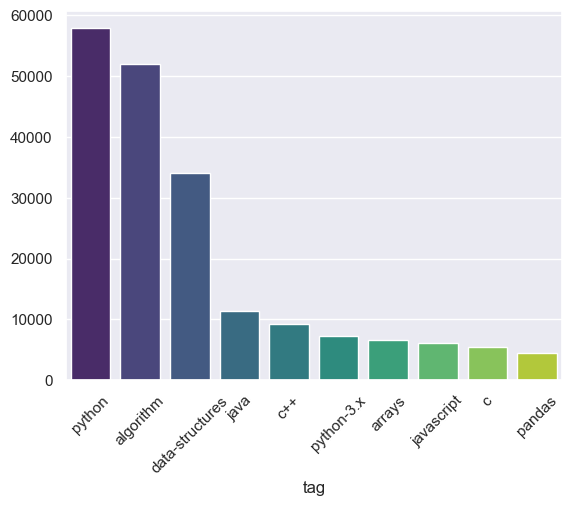

In [35]:
sns.barplot(x = top_ten_tags.index, y = top_ten_tags.values,palette='viridis')
plt.xticks(rotation = 45)

### Plotting top 50 tags

In [36]:
top_fifty_tags = tag_counts.head(50)
print(top_fifty_tags)

tag
python                 57854
algorithm              51909
data-structures        34052
java                   11298
c++                     9245
python-3.x              7224
arrays                  6580
javascript              6171
c                       5390
pandas                  4555
sorting                 4414
c#                      3200
time-complexity         3159
recursion               2877
linked-list             2866
tree                    2764
graph                   2590
math                    2496
django                  2442
list                    2261
dataframe               2207
numpy                   2105
string                  1944
performance             1895
optimization            1882
dynamic-programming     1744
big-o                   1728
dictionary              1573
binary-tree             1524
binary-search-tree      1451
matplotlib              1374
machine-learning        1372
selenium-webdriver      1356
flask                   1328
tkinter   

C:\Users\naren\AppData\Local\Temp\ipykernel_22404\1727394441.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  top_fifty_barplot = sns.barplot(x = top_fifty_tags.index, y = top_fifty_tags.values, palette='viridis')


<Axes: xlabel='tag'>

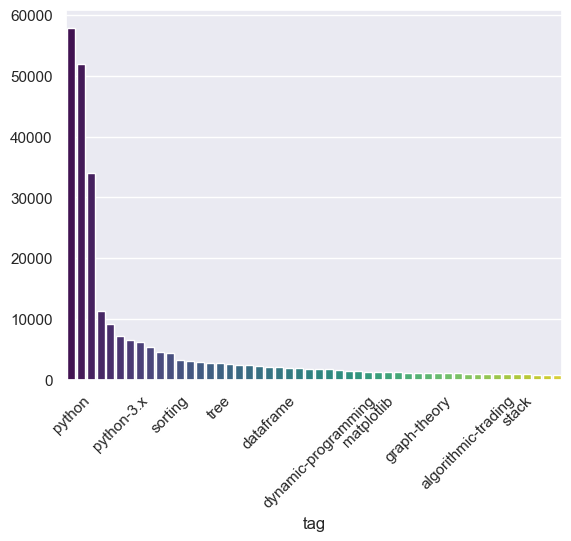

In [37]:
top_fifty_barplot = sns.barplot(x = top_fifty_tags.index, y = top_fifty_tags.values, palette='viridis')
for i, label in enumerate(top_fifty_barplot.xaxis.get_ticklabels()):
    if i%5 != 0:
        label.set_visible(False)
plt.xticks(rotation = 45)
top_fifty_barplot

In [38]:
# Calculate cumulative percentages
cumulative_percentages = 100 * tag_counts.cumsum() / tag_counts.sum()

# Find the number of tags that cover at least 90% of the total occurrences
num_tags_for_90_percent = (cumulative_percentages <= 90).sum()

print("Number of tags that cover atleast 90% of the total occurences",  num_tags_for_90_percent)

Number of tags that cover atleast 90% of the total occurences 1301


### cumulative percentages

In [39]:
pd.options.display.float_format = "{:.2f}%".format
print(100 * tag_counts.head(1350).cumsum() / tag_counts.sum())

tag
python             12.90%
algorithm          24.48%
data-structures    32.07%
java               34.59%
c++                36.65%
                    ...  
instance           90.25%
faiss              90.26%
python-importlib   90.27%
task               90.27%
powerpoint         90.28%
Name: count, Length: 1350, dtype: float64


### Number of questions per tag clearly demonstrates a long tail distribution. Therefore, we can limit the number of tags to be considered.

In [40]:
#Make sure that the column names are all in lower case.

for df in [questions_df, tags_df]:
    df.columns = df.columns.str.lower() 

In [41]:
%%time
# group rows per question id
tags_per_question_df = tags_df.groupby(['id'])['tag'].apply(list)

CPU times: total: 1.22 s
Wall time: 4.66 s


In [42]:
print(tags_per_question_df.head())

id
0      [json, python-polars]
1                   [python]
2    [python, string, input]
3        [python, streamlit]
4      [python, linked-list]
Name: tag, dtype: object


In [43]:
%%time
# we are only interested in text column from `questions_df`
df = questions_df[["id", "title"]].merge(tags_per_question_df.to_frame(), on="id")

CPU times: total: 15.6 ms
Wall time: 84.8 ms


In [44]:
df['tag_count'] = df['tag'].apply(len)

In [45]:
min_tag_count = df['tag_count'].min()
max_tag_count = df['tag_count'].max()
avg_tag_count = df['tag_count'].mean()
print(f"Each question has a minimum of {min_tag_count} tag and a maximum of {max_tag_count} tags. \
The average number of tags per question is {avg_tag_count:.2f}.")

Each question has a minimum of 1 tag and a maximum of 5 tags. The average number of tags per question is 3.46.


### Text Preprocessing

In [46]:
min_title_length = df["title"].str.len().min()
max_title_length = df["title"].str.len().max()

In [47]:
print(f"min_question_length: {min_title_length}")
print(f"max_question_length: {max_title_length}")

min_question_length: 15
max_question_length: 150


## Questions with minimum length 

In [48]:
df[df["title"].str.len() == min_title_length]

,id,title,tag,tag_count
136,136,Docker & gVisor,"[python, typescript, docker, gvisor]",4
205,205,Telegram qr api,"[python, telegram]",2
1078,1078,MODBUS on Linux,"[python, linux, rs485, modbus-tcp, pymodbus]",5
3642,3642,Coloring a text,"[python, text, colors, frame-rate]",4
7888,7888,Running Pyspark,"[python, apache-spark, pyspark]",3
...,...,...,...,...
123782,123782,Minimum Element,"[arrays, algorithm]",2
126552,126552,Optimizing loop,"[c#, algorithm, loops, optimization]",4
127424,127424,Python Exercice,"[python, algorithm]",2
128678,128678,Jalali Calendar,"[c++, algorithm, time, calendar]",4


## Questions with maximum length

In [49]:
df[df["title"].str.len() == max_title_length]

,id,title,tag,tag_count
286,286,"ValueError:The field admin.LogEntry.user was declared with a lazy reference to 'recipes.customuser',but app'recipes'doesn't provide model 'customuser'","[python, django, django-models, django-settings]",4
1828,1828,Baffling! Trying to get ChatGPT to perform an API call to Google Calendar API but it sometimes get stuck saying it made an event but there is no event,"[python, aws-lambda, google-calendar-api, openai-api, chatgpt-api]",5
2043,2043,I have a rabbitmq service in aws ec2 and i have attached an Route 53 record for it but when i am giving the record in code instead of ip getting error,"[python, asp.net, amazon-web-services, devops]",4
2737,2737,Trying to convert code to be compatible with macOS by not using the .exe version of FFmpeg and FFmprobe. Cant open the .mp4 file when i go to run code,"[python, ffmpeg, operating-system, compatibility, ffmpeg-python]",5
2774,2774,tensorflow.python.framework.errors_impl.FailedPreconditionError: C:\Users\Ata Onur Özdemir\PycharmProjects\Emotion_Detection\output is not a directory,"[python-3.x, dictionary, tensorflow, huggingface-transformers, huggingface-trainer]",5
...,...,...,...,...
114620,114620,"A transport vehicle with max 500lb capacity, list of passengers weighing [130, 170, 140. 100] ,shd return [130, 170] to leave exactly 300lb for safety","[java, algorithm, arraylist, bin-packing]",4
120544,120544,Can anyone show me an algorithm to create a function that returns all possible partitions of an array into n subsets while maintaining order of array?,"[arrays, array-algorithms]",2
121373,121373,"I want to solve Project Euler #1 more efficiently by using arithmetic progression formula, but my algorithm returns answers that are just slightly off","[java, algorithm]",2
121560,121560,"How to Recursively Multiply two positive integers without using the * operator (or / operator) ? . You can use addition, subtraction, and bit shifting","[python, algorithm, recursion, dynamic-programming]",4


In [50]:
# we have to keep a list of topics with symbols or digits that people will actually type in because of how nltk handles word tokenization
# this list includes tags that have more than 10,000 questions as of 2020 Jan
topics_with_symbols = ["c#", "c++", ".net", "asp.net", "node.js", "objective-c", "unity3d", "html5", "css3", \
                       "d3.js", "utf-8", "neo4j", "scikit-learn", "f#", "3d", "x86"]

df["title"] = df["title"].str.lower()

df["title_tokenized"] = df["title"].apply(lambda text: [word for word in nltk.word_tokenize(text) \
                                                               if word.isalpha() or word in list("+#") + topics_with_symbols])

In [51]:
df

,id,title,tag,tag_count,title_tokenized
0,0,write/read to/from json a python dict that has a polars df for one or more keys,"[json, python-polars]",2,"[json, a, python, dict, that, has, a, polars, df, for, one, or, more, keys]"
1,1,python: how to remove brackets and single-quotes from csvreader list?,[python],1,"[python, how, to, remove, brackets, and, from, csvreader, list]"
2,2,"multi-line input in python with support of empty lines and check of ""\n"" in the console","[python, string, input]",3,"[input, in, python, with, support, of, empty, lines, and, check, of, in, the, console]"
3,3,streamlit - text color in menu,"[python, streamlit]",2,"[streamlit, text, color, in, menu]"
4,4,nonetype is not subscriptable in linked list,"[python, linked-list]",2,"[nonetype, is, not, subscriptable, in, linked, list]"
...,...,...,...,...,...
129443,129443,recursive implementation of greatest common divisor in python,"[python, algorithm]",2,"[recursive, implementation, of, greatest, common, divisor, in, python]"
129444,129444,speeding up this code — 192 trillion for() loops,"[c#, algorithmic-trading]",2,"[speeding, up, this, code, trillion, for, loops]"
129445,129445,how to make inner object in object using recursive code in javascript,"[javascript, algorithm, recursion]",3,"[how, to, make, inner, object, in, object, using, recursive, code, in, javascript]"
129446,129446,"find two element a and b from set a and b such that on swapping these elements, sum of sets is equal","[algorithm, math]",2,"[find, two, element, a, and, b, from, set, a, and, b, such, that, on, swapping, these, elements, sum, of, sets, is, equal]"


In [52]:
df.rename(columns={'tag':'tags'}, inplace = True)

## Feature Extraction

In [53]:
from collections import Counter

tag_count = Counter()

def count_tag(tags):
    for tag in tags:
        tag_count[tag] += 1

df["tags"].apply(count_tag)

print("The total number of tags:",len(tag_count.values()))

The total number of tags: 12656


In [54]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

most_common_tags = [count[0] for count in tag_count.most_common(1350)]
df["tags"] = df["tags"].progress_apply(lambda tags: [tag for tag in tags if tag in most_common_tags])


100%|██████████| 129448/129448 [00:03<00:00, 41787.51it/s]


In [55]:
df[['title_tokenized']]

,title_tokenized
0,"[json, a, python, dict, that, has, a, polars, df, for, one, or, more, keys]"
1,"[python, how, to, remove, brackets, and, from, csvreader, list]"
2,"[input, in, python, with, support, of, empty, lines, and, check, of, in, the, console]"
3,"[streamlit, text, color, in, menu]"
4,"[nonetype, is, not, subscriptable, in, linked, list]"
...,...
129443,"[recursive, implementation, of, greatest, common, divisor, in, python]"
129444,"[speeding, up, this, code, trillion, for, loops]"
129445,"[how, to, make, inner, object, in, object, using, recursive, code, in, javascript]"
129446,"[find, two, element, a, and, b, from, set, a, and, b, such, that, on, swapping, these, elements, sum, of, sets, is, equal]"


### tf-idf Vectorization

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Dummy tokenizer that bypasses tokenization
def dummy_tokenizer(doc):
    return doc

# Initialize the vectorizer with custom tokenizer
title_vectorizer = TfidfVectorizer(tokenizer=dummy_tokenizer, lowercase=False,max_features=10000, token_pattern= None)

# Fit and transform the title_tokenized column
x_title = title_vectorizer.fit_transform(df["title_tokenized"])

print(x_title)

## Save the embeddings
joblib.dump(title_vectorizer, "tfidf_vectorizer.pkl")

  (0, 4601)	0.3127521925581952
  (0, 5438)	0.2968836647714753
  (0, 5961)	0.23011522115366032
  (0, 5885)	0.24607622763391468
  (0, 3320)	0.15713543788057902
  (0, 2323)	0.39272975912285285
  (0, 6413)	0.32950404782436366
  (0, 3778)	0.2728686361987966
  (0, 8866)	0.21193485602274087
  (0, 2345)	0.35747153481542077
  (0, 6857)	0.15294482000395992
  (0, 4)	0.22992906298316468
  (0, 4533)	0.29936505768957805
  (1, 4851)	0.2954932357494737
  (1, 3406)	0.2726679857546049
  (1, 321)	0.2426113250683118
  (1, 946)	0.6673846474303045
  (1, 7326)	0.45720667885543126
  (1, 8998)	0.16573138686351616
  (1, 3947)	0.20222832750923486
  (1, 6857)	0.238059358700427
  (2, 1704)	0.41737527495607935
  (2, 8868)	0.14235512661723887
  (2, 1257)	0.30168658345957877
  (2, 4825)	0.35414012281066654
  :	:
  (129446, 7917)	0.24938520022755414
  (129446, 8881)	0.2731399059828839
  (129446, 2863)	0.2426739107086155
  (129446, 7913)	0.18957790696249247
  (129446, 9248)	0.1740323947844698
  (129446, 2727)	0.1959464

['tfidf_vectorizer.pkl']

In [57]:
# there is a problematic tag named "nan" which causes string comparison error
df["tags"] = df["tags"].apply(lambda tags: [tag if not isinstance(tag, float) else "nan" for tag in tags])

In [58]:
x_title = x_title *2

In [59]:
df

,id,title,tags,tag_count,title_tokenized
0,0,write/read to/from json a python dict that has a polars df for one or more keys,"[json, python-polars]",2,"[json, a, python, dict, that, has, a, polars, df, for, one, or, more, keys]"
1,1,python: how to remove brackets and single-quotes from csvreader list?,[python],1,"[python, how, to, remove, brackets, and, from, csvreader, list]"
2,2,"multi-line input in python with support of empty lines and check of ""\n"" in the console","[python, string, input]",3,"[input, in, python, with, support, of, empty, lines, and, check, of, in, the, console]"
3,3,streamlit - text color in menu,"[python, streamlit]",2,"[streamlit, text, color, in, menu]"
4,4,nonetype is not subscriptable in linked list,"[python, linked-list]",2,"[nonetype, is, not, subscriptable, in, linked, list]"
...,...,...,...,...,...
129443,129443,recursive implementation of greatest common divisor in python,"[python, algorithm]",2,"[recursive, implementation, of, greatest, common, divisor, in, python]"
129444,129444,speeding up this code — 192 trillion for() loops,"[c#, algorithmic-trading]",2,"[speeding, up, this, code, trillion, for, loops]"
129445,129445,how to make inner object in object using recursive code in javascript,"[javascript, algorithm, recursion]",3,"[how, to, make, inner, object, in, object, using, recursive, code, in, javascript]"
129446,129446,"find two element a and b from set a and b such that on swapping these elements, sum of sets is equal","[algorithm, math]",2,"[find, two, element, a, and, b, from, set, a, and, b, such, that, on, swapping, these, elements, sum, of, sets, is, equal]"


In [60]:
X = hstack([x_title])
y = df[["tags"]]

In [61]:
y

,tags
0,"[json, python-polars]"
1,[python]
2,"[python, string, input]"
3,"[python, streamlit]"
4,"[python, linked-list]"
...,...
129443,"[python, algorithm]"
129444,"[c#, algorithmic-trading]"
129445,"[javascript, algorithm, recursion]"
129446,"[algorithm, math]"


In [62]:
y.shape

(129448, 1)

### MultiLabelBinarizer for Converting Tags to Binary Matrix

In [63]:
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize the MultiLabelBinarizer
multi_label_binarizer = MultiLabelBinarizer()

# Transform the list of tags into a binary matrix
# 'y["tags"]' should be a list-like structure where each element is a list of tags for a particular instance
y = multi_label_binarizer.fit_transform(y["tags"])

In [64]:
y.shape

(129448, 1350)

## Train-test split

In [65]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [66]:
y_classes = multi_label_binarizer.classes_
joblib.dump(y_classes, 'y_classes.pickle')

['y_classes.pickle']

In [67]:
X_train.shape

(103558, 10000)

## Model building and training

In [68]:
%%time

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(n_jobs=-1)

clf = OneVsRestClassifier(sgd_classifier)
clf.fit(X_train, y_train)

CPU times: total: 5min 30s
Wall time: 3min 33s


OneVsRestClassifier(estimator=SGDClassifier(n_jobs=-1))

In [69]:
joblib.dump(clf, "sgd_classifier.pkl")

['sgd_classifier.pkl']

In [70]:
# %%time
# import json

# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import SGDClassifier, LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# rf_classifier = RandomForestClassifier(n_jobs=-1)

# rf_clf = OneVsRestClassifier(rf_classifier)
# rf_clf.fit(X_train, y_train)

In [71]:
# import joblib
# joblib.dump(rf_clf, "one_vs_rest_classifier.pkl")

In [72]:
y_train.shape

(103558, 1350)

In [73]:
X_test.shape

(25890, 10000)

In [74]:
y_pred = clf.predict(X_test)

In [75]:
%%time

from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)

print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"fscore: {fscore}")
print(f"support: {support}")

precision: [0. 0. 0. ... 0. 0. 0.]
recall: [0. 0. 0. ... 0. 0. 0.]
fscore: [0. 0. 0. ... 0. 0. 0.]
support: [28 41 37 ... 11  4  2]
CPU times: total: 859 ms
Wall time: 3.6 s


c:\Users\naren\anaconda3\envs\sharp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\naren\anaconda3\envs\sharp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
from sklearn.metrics import hamming_loss

hamming = []

for i, (test, pred) in enumerate(zip(y_test.T, y_pred.T)):
    hamming.append(hamming_loss(test, pred))

In [77]:
metric_df = pd.DataFrame(data=[precision, recall, fscore, hamming, support],
                         index=["Precision", "Recall", "F-1 score", "Hamming loss", "True count"],
                         columns=y_classes)

In [78]:
metric_df

,2d,3d,a-star,abstract-data-type,abstract-syntax-tree,adafruit-circuitpython,adjacency-list,adjacency-matrix,aes,aiogram,...,xor,xpath,yaml,yfinance,yolo,yolov5,yolov8,youtube,youtube-api,zip
Precision,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.00%,...,0.00%,0.00%,0.64%,1.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Recall,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.52%,...,0.00%,0.00%,0.78%,0.36%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
F-1 score,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.69%,...,0.00%,0.00%,0.70%,0.53%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Hamming loss,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
True count,28.00%,41.00%,37.00%,15.00%,11.00%,6.00%,18.00%,15.00%,5.00%,23.00%,...,11.00%,21.00%,9.00%,11.00%,17.00%,6.00%,18.00%,11.00%,4.00%,2.00%


In [79]:
top_ten_tags_list = [
    'python',
    'algorithm',
    'data-structures',
    'python-3.x',
    'list',
    'sorting',
    'recursion',
    'numpy',
    'arrays',
    'dictionary'
]

metric_df[top_ten_tags_list]

,python,algorithm,data-structures,python-3.x,list,sorting,recursion,numpy,arrays,dictionary
Precision,0.86%,0.83%,0.84%,0.00%,0.00%,0.65%,0.59%,0.88%,0.74%,0.54%
Recall,0.79%,0.74%,0.56%,0.00%,0.00%,0.47%,0.48%,0.31%,0.02%,0.31%
F-1 score,0.83%,0.78%,0.67%,0.00%,0.00%,0.55%,0.53%,0.46%,0.04%,0.40%
Hamming loss,0.15%,0.16%,0.14%,0.06%,0.02%,0.03%,0.02%,0.01%,0.05%,0.01%
True count,11647.00%,10253.00%,6842.00%,1428.00%,467.00%,865.00%,541.00%,430.00%,1281.00%,289.00%


In [25]:
import numpy as np
metric_df[top_ten_tags_list].apply(np.mean, axis=1)

NameError: name 'metric_df' is not defined

Text(0, 0.5, 'Recall')

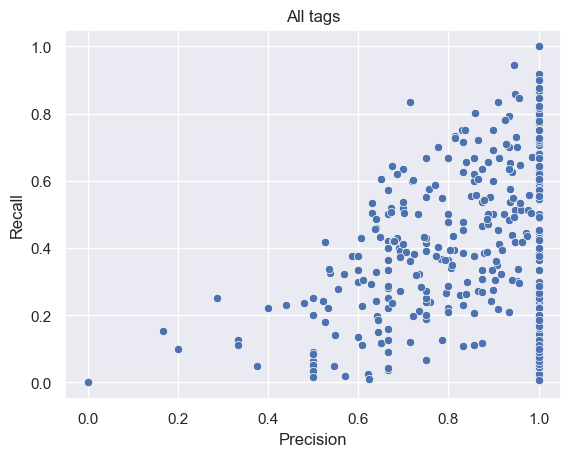

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=metric_df.loc["Precision"], y=metric_df.loc["Recall"])
plt.title("All tags")
plt.xlabel("Precision")
plt.ylabel("Recall")

In [178]:
def print_pred_test_n(pred, test, n):
    pred_n = pd.DataFrame(y_pred[n:n+1], columns=y_classes)
    pred_n = pred_n.sum()
    print("Prediction:")
    print(pred_n[pred_n.values > 0])
    
    test_n = pd.DataFrame(y_test[n:n+1], columns=y_classes)
    test_n = test_n.sum()
    print("\nActual:")
    print(test_n[test_n.values > 0])
    
print_pred_test_n(y_pred, y_test, 150)

Prediction:
python    1
dtype: int64

Actual:
python     1
youtube    1
dtype: int64


In [179]:
import joblib
import nltk
import pandas as pd

vectorizer = joblib.load("tfidf_vectorizer.pkl")
# clf = joblib.load("one_vs_rest_classifier.pkl")

def dummy_tokenizer(doc):
    return doc

def predict_tags(question):
    # Load the saved vectorizer and classifier

    y_classes = joblib.load("y_classes.pickle")
    
    topics_with_symbols = ["c#", "c++", ".net", "asp.net", "node.js", "objective-c", "unity3d", "html5", "css3", 
                           "d3.js", "utf-8", "neo4j", "scikit-learn", "f#", "3d", "x86"]
    
    question = question.lower()

    # Tokenize the question
    tokenized_question = [word for word in nltk.word_tokenize(question) if word.isalpha() or word in list("+#") + topics_with_symbols]

    # Transform the tokenized question using the loaded vectorizer
    x_title = vectorizer.transform([tokenized_question])

    # Predict the tags using the loaded classifier
    y_pred = clf.predict(x_title)
    print(y_pred)
    
    return [y_classes[i] for i in range(len(y_classes)) if y_pred[0][i] == 1 ]


# Building  a Hybrid Model

In [180]:
%%time
import json
import re
import joblib
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def dummy_tokenizer(doc):
    return doc

# Filters out tags that are substrings of other tags
def filter_superstrings(tags):
    tags.sort(key=len, reverse=True)
    tags = [tag.replace('-', ' ') for tag in tags]
    filtered_tags = []
    lemmatized_tags = set()
    
    for tag in tags:
        lemma_tag = lemmatizer.lemmatize(tag)
        if lemma_tag not in lemmatized_tags:
            lemmatized_tags.add(lemma_tag)
            filtered_tags.append(tag)
    return filtered_tags      


clf = joblib.load('sgd_classifier.pkl')
y_classes = joblib.load("y_classes.pickle")
vectorizer = joblib.load('tfidf_vectorizer.pkl')

with open('top_tags.json', 'r') as file:
    all_tags = json.load(file)
all_tags = sorted(all_tags, key=lambda x: len(x), reverse=True)

def hybrid_model_predict(question):
    topics_with_symbols = ["c#", "c++", ".net", "asp.net", "node.js", "objective-c", "unity3d", "html5", "css3", 
                           "d3.js", "utf-8", "neo4j", "scikit-learn", "f#", "3d", "x86"]
    
    question = question.lower()
    tokenized_question = [word for word in nltk.word_tokenize(question) if word.isalpha() or word in list("+#") + topics_with_symbols]
    x_title = vectorizer.transform([' '.join(tokenized_question)])  # Use a space-joined string

    y_pred = clf.predict(x_title)
    one_vs_rest_predictions = [y_classes[i] for i in range(len(y_classes)) if y_pred[0][i] == 1]

    KeyWords = []
    if '?' in question:
        question = question.replace('?', '')
    question = question.lower()

    for keyword in all_tags:
        pattern = r'\b' + re.escape(keyword.lower()) + r'\b'
        if re.search(pattern, question):
            KeyWords.append(keyword)
            question = re.sub(pattern, '', question)

    keywords_based_prediction = list(set(KeyWords))
    final_prediction = list(set(one_vs_rest_predictions + keywords_based_prediction))
    final_prediction = filter_superstrings(final_prediction)
    return final_prediction



CPU times: total: 297 ms
Wall time: 848 ms


In [80]:
# Example usage
question = "how to sort a list of dictionaries by a value of the dictionary in python?"
hybrid_model_predict(question)


NameError: name 'hybrid_model_predict' is not defined

# SOLO Classification

### Key Concepts

- **`relation_keywords`**: 
  - This is a list of tuples representing significant relationships between keywords in the question. 
  - These relationships are extracted based on dependency parsing, focusing on subjects, objects, and other key grammatical roles.

- **`avg_distance`**: 
  - This is the average of the pairwise distances (cosine similarities) between the embeddings of keywords in the question. 
  - A lower average distance indicates that the concepts are semantically closer to each other, suggesting better integration.

- **`max_distance`**: 
  - This is the maximum distance between any two keyword embeddings in the question. 
  - A lower maximum distance indicates that even the most distant concepts in the question are still relatively close, which may suggest a very tight integration of ideas.


### Thresholds

**`strong_threshold`:**
- Determines a threshold for strong keyword relationships.
- Helps classify questions as "Relational" or "Extended Abstract".
- Example: `strong_threshold = 0.2` indicates strong relationships below this distance.


**`weak_threshold`:**
- Sets a boundary for weak keyword relationships.
- Influences classification towards "Multi-structural" if exceeded.
- Example: `weak_threshold = 0.4` identifies weak relationships above this distance.



### Predicting the solo class for each question

In [182]:
# Importing necessary libraries
import pandas as pd
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
import numpy as np
import re
import json
from nltk.tokenize import word_tokenize
import spacy

# Load spaCy model for English
nlp = spacy.load('en_core_web_sm')

# Initialize BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to generate embedding for a keyword, skipping stopwords
def get_embedding(text):
    # Tokenize text using spaCy
    tokens = nlp(text)
    
    # Filter out stopwords and join tokens
    content_words = [token.text for token in tokens if not token.is_stop]
    filtered_text = " ".join(content_words)
    
    # Tokenize filtered text with BERT tokenizer
    inputs = tokenizer(filtered_text, return_tensors='pt')
    
    # Get BERT model outputs
    outputs = model(**inputs)
    
    # Calculate mean of last hidden state to get embedding
    embedding = outputs.last_hidden_state.mean(dim=1).flatten().detach().numpy()
    return embedding

# Function to calculate cosine similarity
def cosine_distance(embedding1, embedding2):
    return cosine(embedding1, embedding2)

# Function to calculate Euclidean distance
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

# Function to generate similarity matrix for a list of keywords
def get_distance_matrix(keywords, distance_metric=cosine_distance):
    # Generate embeddings for each keyword
    keyword_embeddings = {kw: get_embedding(kw) for kw in keywords}
    
    # Initialize the similarity matrix
    similarity_matrix = [[0] * len(keywords) for _ in range(len(keywords))]
    
    # Calculate pairwise similarities
    for i in range(len(keywords)):
        for j in range(i + 1, len(keywords)):
            sim_score = distance_metric(keyword_embeddings[keywords[i]], keyword_embeddings[keywords[j]])
            similarity_matrix[i][j] = round(sim_score, 2)
            similarity_matrix[j][i] = round(sim_score, 2)
            
    return similarity_matrix

# Function to calculate sum of distances in upper triangle of a matrix
def distances_sum(distance_matrix):
    return float(np.sum(np.triu(distance_matrix)))

# Function to lemmatize a word using spaCy
def lemmatize_word(word):
    doc = nlp(word)
    return doc[0].lemma_

# Lemmatize the extended abstract keywords
extended_abstract_keywords = [
    "difference", "implementation", "better", "best", "efficient", 
    "general-purpose", "general purpose", "specific", "layered", "generate", 
    "permutations", "optimize", "language", "store", "lexicographic", 
    "comparison", "design", "efficiency", "complexity", "strategy", 
    "approach", "methodology", "performance", "technique", "pattern", 
    "structure", "framework", "model", "simulation", "behavior", 
    "heuristic", "optimization", "benchmark", "constraint", "trade-off", 
    "evaluation", "validation", "robust", "integration", "architecture", 
    "composition", "synthesis", "abstraction", "visualization", 
    "scalability", "anomaly", "extension", "solution", "problem-solving", 
    "innovation", "reliability", "flexibility", "adaptation", "modification", 
    "reconfiguration", "transformation", "emergent", "novelty", "complex",
    "evolution", "iteration"
]

extended_abstract_keywords_lemmatized = [lemmatize_word(word) for word in extended_abstract_keywords]

# Function to analyze syntactic structure of a question
def analyze_question_structure(question):
    doc = nlp(question)
    relations = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj", "pobj", "attr"):
            relations.append((token.head.text, token.text))
    return relations

# Function to determine SOLO taxonomy level
def get_solo_level(question, strong_threshold=0.18, weak_threshold=0.2325):
    keywords = hybrid_model_predict(question)  # Assuming hybrid_model_predict() returns relevant keywords
    
    if not keywords:
        return "Pre-structural"
    
    if len(keywords) == 1:
        return "Uni-structural"
    
    distances = get_distance_matrix(keywords)
    max_distance = np.max(distances)
    avg_distance = distances_sum(distances) / len(keywords)
    
    # Analyze question structure to find relationships
    relations = analyze_question_structure(question)
    relation_keywords = [relation for relation in relations if (relation[0] in keywords and relation[1] in keywords)]
    
    if not relation_keywords:
        if max_distance >= weak_threshold:
            return 'Multi-structural'
        
        else:
            question_embedding = get_embedding(question)
            min_keyword_question_distance = min(
                cosine(question_embedding, get_embedding(kw)) for kw in keywords
            )
            tokenized_question = [lemmatize_word(token.text) for token in nlp(question)]
            for word in keywords:
                if word in tokenized_question:
                    for word in extended_abstract_keywords_lemmatized:
                        if word in tokenized_question:
                            return "Extended Abstract"
                    return 'Uni-structural'
                
            if min_keyword_question_distance > 0.4:
                return 'Pre-structural'
            else:
                
                for word in extended_abstract_keywords_lemmatized:
                    if word in tokenized_question:
                        return "Extended Abstract"
                return 'Uni-structural'
    
    if relation_keywords:
        if avg_distance <= strong_threshold:
            return "Relational"
        
        if max_distance <= strong_threshold:
            return "Extended Abstract"
        
        return 'Relational'


In [183]:
question = 'what is the difference between python\'s list methods append and extend?'

In [184]:
keywords = hybrid_model_predict(question)
keywords

['methods', 'extend', 'append', 'python', 'list']

In [185]:
get_solo_level(question)

'Multi-structural'

In [188]:
sample_df = df[['title']].head(20)
sample_df['predicted_tags'] = sample_df.title.apply(hybrid_model_predict)
sample_df['Distance Matrix'] = sample_df['predicted_tags'].apply(get_distance_matrix)
sample_df['Sum_distances'] = sample_df['Distance Matrix'].apply(distances_sum) 
sample_df['solo class'] = sample_df['title'].apply(get_solo_level)
sample_df.head(20)

,title,predicted_tags,Distance Matrix,Sum_distances,solo class
0,write/read to/from json a python dict that has a polars df for one or more keys,"[algorithm, python, write, read, json, dict]","[[0, 0.17, 0.23, 0.2, 0.31, 0.27], [0.17, 0, 0.18, 0.2, 0.32, 0.28], [0.23, 0.18, 0, 0.11, 0.34, 0.31], [0.2, 0.2, 0.11, 0, 0.33, 0.25], [0.31, 0.32, 0.34, 0.33, 0, 0.38], [0.27, 0.28, 0.31, 0.25, 0.38, 0]]",3.88%,Relational
1,python: how to remove brackets and single-quotes from csvreader list?,"[algorithm, python, remove, list]","[[0, 0.17, 0.16, 0.16], [0.17, 0, 0.16, 0.22], [0.16, 0.16, 0, 0.17], [0.16, 0.22, 0.17, 0]]",1.04%,Uni-structural
2,"multi-line input in python with support of empty lines and check of ""\n"" in the console","[algorithm, python, with]","[[0, 0.17, 0.38], [0.17, 0, 0.37], [0.38, 0.37, 0]]",0.92%,Multi-structural
3,streamlit - text color in menu,[algorithm],[[0]],0.00%,Uni-structural
4,nonetype is not subscriptable in linked list,"[linked list, algorithm]","[[0, 0.31], [0.31, 0]]",0.31%,Multi-structural
5,linkedin image/video api upload 403 forbidden error,"[algorithm, image]","[[0, 0.14], [0.14, 0]]",0.14%,Uni-structural
6,how to dynamically create class methods in python using decorators?,"[algorithm, methods, python, class]","[[0, 0.12, 0.17, 0.2], [0.12, 0, 0.18, 0.18], [0.17, 0.18, 0, 0.23], [0.2, 0.18, 0.23, 0]]",1.08%,Uni-structural
7,module import error for python_pylint when using super-linter/super-linter@v6.7.0,"[algorithm, module, import]","[[0, 0.14, 0.18], [0.14, 0, 0.14], [0.18, 0.14, 0]]",0.46%,Uni-structural
8,different basicblocks share the same object id in llvm,[algorithm],[[0]],0.00%,Uni-structural
9,"cross-validation function returns ""unknown label type: (array([0.0, 1.0], dtype=object),)""","[algorithm, function, returns, array]","[[0, 0.16, 0.21, 0.14], [0.16, 0, 0.18, 0.15], [0.21, 0.18, 0, 0.16], [0.14, 0.15, 0.16, 0]]",1.00%,Relational


In [192]:
sample_df = df.head(1000)
sample_df['solo class'] = sample_df['title'].apply(get_solo_level)


C:\Users\naren\AppData\Local\Temp\ipykernel_12972\3927112521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['solo class'] = sample_df['title'].apply(get_solo_level)


In [197]:
sample_df['solo class'].value_counts()

solo class
Uni-structural       578
Multi-structural     276
Relational            66
Pre-structural        43
Extended Abstract     37
Name: count, dtype: int64

In [198]:
sample_df = df.head(10000)
sample_df['solo class'] = sample_df['title'].apply(get_solo_level)
sample_df['solo class'].value_counts()


C:\Users\naren\AppData\Local\Temp\ipykernel_12972\234418899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['solo class'] = sample_df['title'].apply(get_solo_level)


solo class
Uni-structural       5728
Multi-structural     2933
Relational            543
Pre-structural        466
Extended Abstract     330
Name: count, dtype: int64